# Лабораторная работа по модулю “Построение моделей”

В данной работе предлагается решить задачу мультиклассовойклассификации для датасета флагов различных стран (https://archive.ics.uci.edu/ml/datasets/Flags)

1. Загрузить данные из папки Data Folder

2. Провести описательный анализ предложенных данных

3. Предложить стратегию по работе с категориальными переменными

4. Провести углубленный анализ данных (корреляции переменных,визуализация взаимосвязей)

5. Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)

6. Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)

7. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)

8. Решить задачу мультиклассовойклассификации и предсказать религию страны(religion)по деталям ее флага

9. РассчитатьFeature Importances для переменных модели

10. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

11. Построить Confusion Matrix для ваших результатов


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve
from pylab import rcParams
import seaborn as sns
from scipy.stats import pearsonr
import seaborn as sbs
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix

# Загрузить данные из папки Data Folder

In [7]:
cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

In [8]:
data = pd.read_csv('flag.data',header=None,names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


# Провести описательный анализ предложенных данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
name          194 non-null object
landmass      194 non-null int64
zone          194 non-null int64
area          194 non-null int64
population    194 non-null int64
language      194 non-null int64
religion      194 non-null int64
bars          194 non-null int64
stripes       194 non-null int64
colours       194 non-null int64
red           194 non-null int64
green         194 non-null int64
blue          194 non-null int64
gold          194 non-null int64
white         194 non-null int64
black         194 non-null int64
orange        194 non-null int64
mainhue       194 non-null object
circles       194 non-null int64
crosses       194 non-null int64
saltires      194 non-null int64
quarters      194 non-null int64
sunstars      194 non-null int64
crescent      194 non-null int64
triangle      194 non-null int64
icon          194 non-null int64
animate       194 non-null int64
te

In [13]:
categoricals = ['landmass','zone','language','mainhue','topleft','botright']
dummies = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
continuous = ['area', 'population', 'bars', 'stripes', 'colours','circles', 'crosses', 'saltires', 'quarters', 'sunstars']
target = 'religion'

In [14]:
data[continuous].describe()

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,700.046392,23.268041,0.453608,1.551546,3.463918,0.170103,0.149485,0.092784,0.149485,1.386598
std,2170.927932,91.934085,1.038339,2.328005,1.300154,0.463075,0.385387,0.290879,0.435860,4.396186
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,4.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,471.250000,14.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,22402.000000,1008.000000,5.000000,14.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000


In [15]:
data[data.area == 0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue
33,Cayman-Islands,1,4,0,0,1,1,0,0,6,...,1,1,4,0,0,1,1,1,white,blue
41,Cook-Islands,6,3,0,0,1,1,0,0,4,...,1,1,15,0,0,0,0,0,white,blue
48,Dominica,1,4,0,0,1,1,0,0,6,...,0,0,10,0,0,0,1,0,green,green


In [16]:
data[data.population==0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
12,Bahamas,1,4,19,0,1,1,0,3,3,...,0,0,0,0,1,0,0,0,blue,blue
13,Bahrain,5,1,1,0,8,2,0,0,2,...,0,0,0,0,0,0,0,0,white,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
17,Belize,1,4,23,0,1,1,0,2,8,...,0,0,0,0,0,1,1,1,red,red
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue


Судя по названиям стран значения 0 в площади и населении - просто результат грубого округления.

In [18]:
np.sum(data[dummies].max()!=1) + np.sum(data[dummies].min()!=0)

0

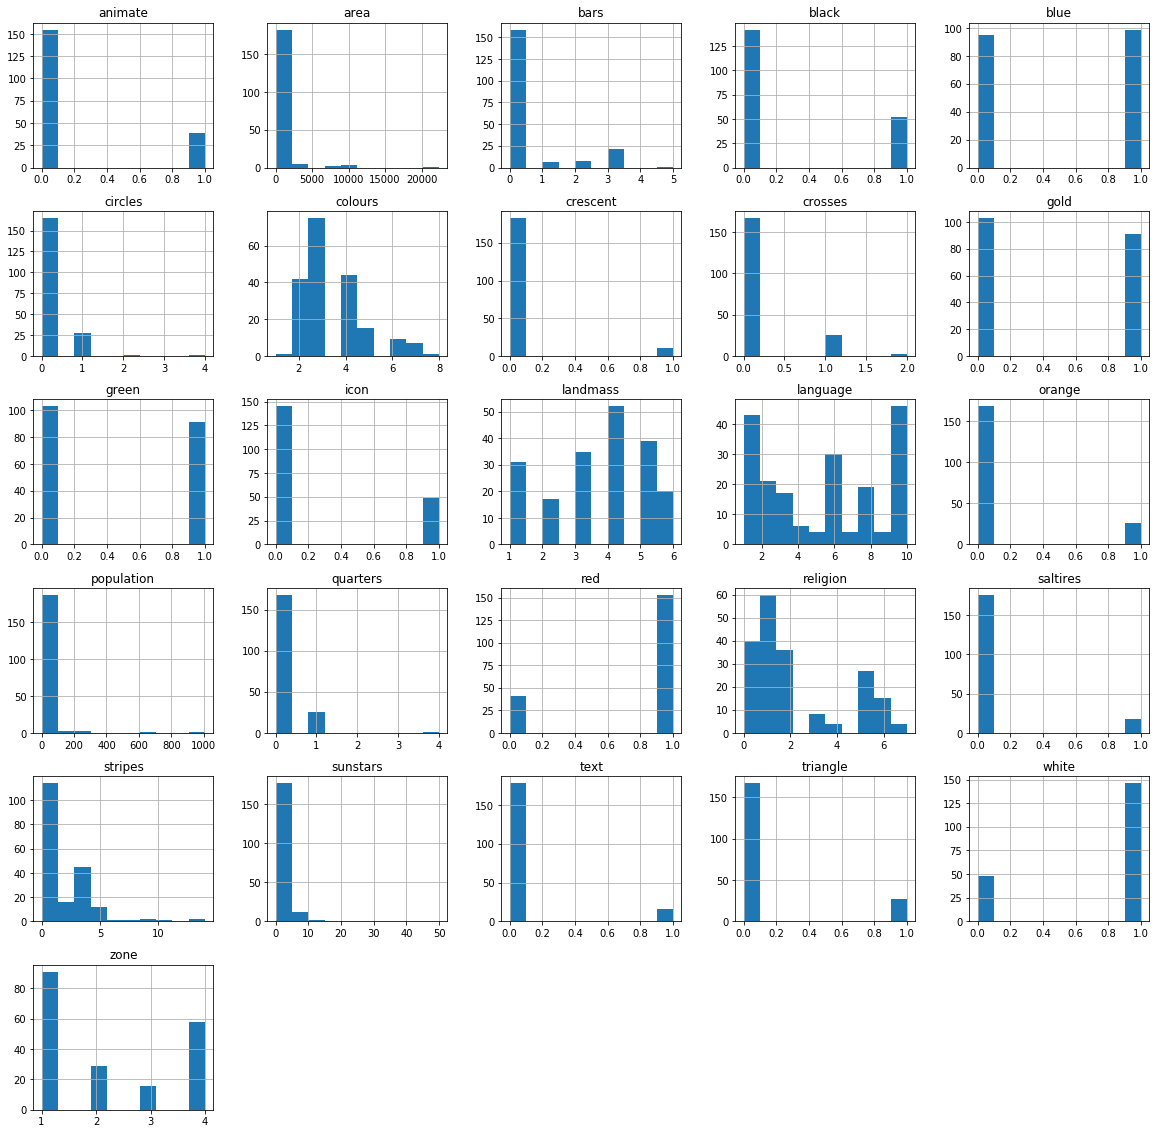

In [57]:
rcParams['figure.figsize'] = 20,20
data.hist()
plt.show()

# Предложить стратегию по работе с категориальными переменными

In [20]:
total = 0
for cat in categoricals:
    total += len(data[cat].unique())
    print(cat,len(data[cat].unique()))
print('Всего:',total)

landmass 6
zone 4
language 10
mainhue 8
topleft 7
botright 8
Всего: 43


Т.к. количество категорийных переменных невелико, то будем использовать one-hot encoding

# Провести углубленный анализ данных (корреляции переменных,визуализация взаимосвязей)

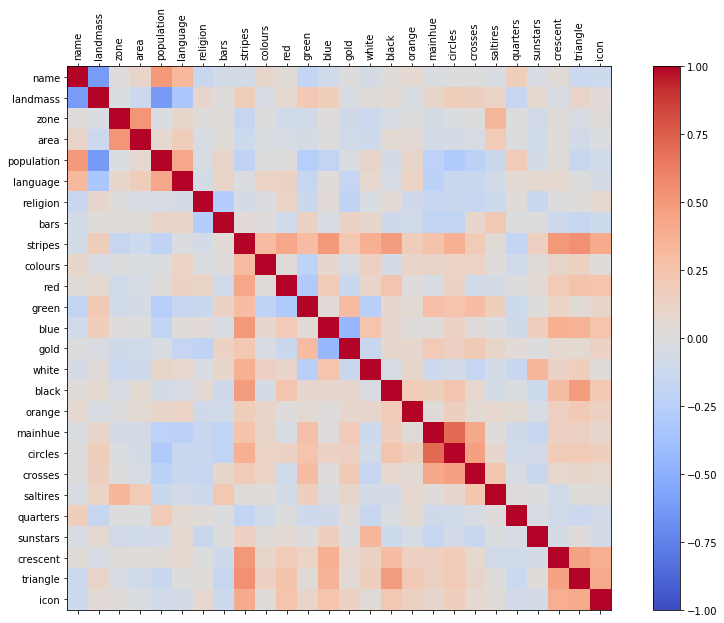

In [21]:
corr = data.drop(['name','topleft','botright'],axis=1).corr()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

Религия больше всего коррелирует с такими элементами флага, как landmass,bars, red, green, gold.

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Belotelov/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


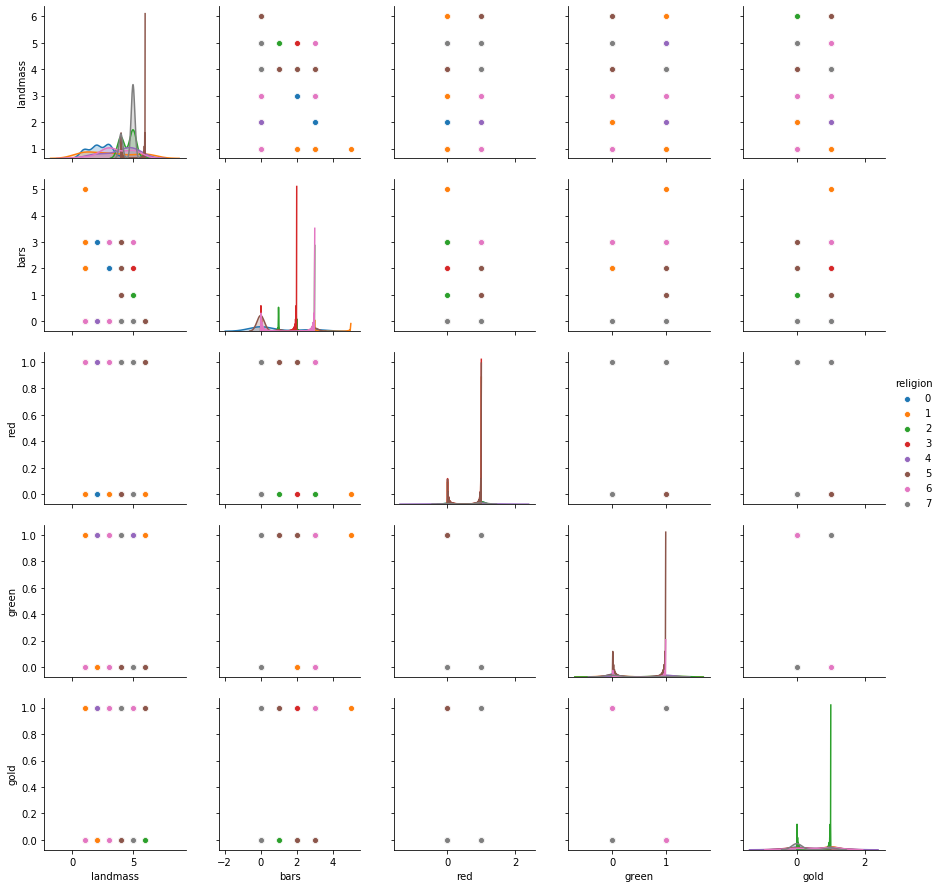

In [24]:
sbs.pairplot(data = data,vars=['landmass','bars','red','green','gold'], hue='religion')

Из графиков недостаточно видны закономерности

In [25]:
y = data[target]

In [26]:
y.value_counts()

1    60
0    40
2    36
5    27
6    15
3     8
7     4
4     4
Name: religion, dtype: int64

Классы сильно разбалансированы

# Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)

In [27]:
X = pd.concat([data[continious],data[dummies],pd.get_dummies(data[categoricals])],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 48 columns):
area               194 non-null int64
population         194 non-null int64
bars               194 non-null int64
stripes            194 non-null int64
colours            194 non-null int64
circles            194 non-null int64
crosses            194 non-null int64
saltires           194 non-null int64
quarters           194 non-null int64
sunstars           194 non-null int64
red                194 non-null int64
green              194 non-null int64
blue               194 non-null int64
gold               194 non-null int64
white              194 non-null int64
black              194 non-null int64
orange             194 non-null int64
crescent           194 non-null int64
triangle           194 non-null int64
icon               194 non-null int64
animate            194 non-null int64
text               194 non-null int64
landmass           194 non-null int64
zone               19

In [30]:
sss = StratifiedShuffleSplit(n_splits=1,test_size=.2)
for trn_idx,tst_idx in sss.split(X,y):
    X_train,y_train = X.iloc[trn_idx],y.iloc[trn_idx]
    X_test,y_test = X.iloc[tst_idx],y.iloc[tst_idx]
    
assert len(X_train)+len(X_test) == len(y_train)+len(y_test) == len(X) == len(y)

Базовая модель и ее характеристики:

In [32]:
rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train,y_train):
    X_train_fold,y_train_fold = X.iloc[trn_idx],y.iloc[trn_idx]
    X_test_fold,y_test_fold = X.iloc[tst_idx],y.iloc[tst_idx]
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train,y_train)
print (score_on_train/3)
print(rfc.score(X_test,y_test))

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.5806938159879337
0.6410256410256411


In [34]:
pf = PolynomialFeatures(degree=3,interaction_only=True,include_bias=False)
X_poly = pd.concat([pd.DataFrame(pf.fit_transform(X[continious])),data[dummies],pd.get_dummies(data[categoricals])],axis=1)
X_poly.head()

,0,1,2,3,4,5,6,7,8,9,...,topleft_red,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white
0,648.0,16.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
1,29.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,1,0
2,2388.0,20.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
for trn_idx,tst_idx in sss.split(X_poly,y):
    X_train_poly,y_train_poly = X_poly.iloc[trn_idx],y.iloc[trn_idx]
    X_test_poly,y_test_poly = X_poly.iloc[tst_idx],y.iloc[tst_idx]

In [36]:
rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train_poly,y_train_poly):
    X_train_fold,y_train_fold = X_poly.iloc[trn_idx],y.iloc[trn_idx]
    X_test_fold,y_test_fold = X_poly.iloc[tst_idx],y.iloc[tst_idx]
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train_poly,y_train_poly)
print (score_on_train/3)
print(rfc.score(X_test_poly,y_test_poly))

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.49685771744595275
0.5897435897435898


In [38]:
X_pca = pd.DataFrame(PCA(n_components=round(len(X.columns)/3)).fit_transform(X))

In [39]:
for trn_idx,tst_idx in sss.split(X_pca,y):
    X_train_pca,y_train_pca = X_pca.iloc[trn_idx],y.iloc[trn_idx]
    X_test_pca,y_test_pca = X_pca.iloc[tst_idx],y.iloc[tst_idx]

In [40]:
rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train_pca,y_train_pca):
    X_train_fold,y_train_fold = X_pca.iloc[trn_idx],y.iloc[trn_idx]
    X_test_fold,y_test_fold = X_pca.iloc[tst_idx],y.iloc[tst_idx]
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train_pca,y_train_pca)
print (score_on_train/3)
print(rfc.score(X_test_pca,y_test_pca))

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.47096530920060325
0.5384615384615384


Тесты выше показали что ни уменьшение ни увеличение размерности признакового множества особо не влияет на RFC оценку модели.

# Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)

Oversampling

In [41]:
classes_count = y.value_counts()
max_class_count = classes_count.max()

X_over = X.copy()
y_over = y.copy()

In [42]:
for cls in zip(classes_count,classes_count.index):
    if cls[0] != max_class_count:
        idx = np.random.choice(y[y==cls[1]].index,size = max_class_count-cls[0])
        X_add = X.iloc[idx]
        y_add = y.iloc[idx]
        X_over = X_over.append(X_add)
        y_over = y_over.append(y_add)

In [43]:
y_over.value_counts()

7    60
6    60
5    60
4    60
3    60
2    60
1    60
0    60
Name: religion, dtype: int64

In [45]:
X_train_over,X_test_over,y_train_over,y_test_over = train_test_split(X_over,y_over,test_size=.2, random_state=42)

In [46]:
rfc = RandomForestClassifier(max_depth=20,min_samples_leaf=5,n_estimators=100,n_jobs=-1,random_state=42)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=3,random_state=42).split(X_train_over,y_train_over):
    X_train_fold,y_train_fold = X_over.iloc[trn_idx],y_over.iloc[trn_idx]
    X_test_fold,y_test_fold = X_over.iloc[tst_idx],y_over.iloc[tst_idx]
    rfc.fit(X_train_fold,y_train_fold)
    score_on_train += rfc.score(X_test_fold,y_test_fold)

rfc.fit(X_train_over,y_train_over)
print (score_on_train/3)
print(rfc.score(X_test_over,y_test_over))

/Users/Belotelov/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.5338541666666666
0.8541666666666666


Oversampling показывает хороший результат, поэтому рекомендуется к использованию

Undersampling скорее всего не будет работать, тк малые классы очень маленькие и эта техника сильно сократит датасет 

# Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)

In [47]:
params = {'n_estimators':[10,50,100,200,500,1000],
          'max_depth':[5,10,15,20,30],
          'min_samples_leaf':[1,5,10,20],
          'random_state':[42],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=1,n_jobs=-1,cv=3)
rf_grid.fit(X_train_over,y_train_over)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [48]:
params = {'penalty':['l2'],
          'max_iter':[100,500,1000],
          'multi_class':['multinomial'],
          'n_jobs':[-1],
          'C':[0.01,0.1,0.5,1.0],
          'solver':['newton-cg','sag','saga','lbfgs']}
lr_grid = GridSearchCV(LogisticRegression(),param_grid=params,verbose=1,n_jobs=-1,cv=3)
lr_grid.fit(X_train_over,y_train_over)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   29.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1.0],
                         'max_iter': [100, 500, 1000],
                         'multi_class': ['multinomial'], 'n_jobs': [-1],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, retu

# Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

In [50]:
rf_pred = rf_grid.predict(X_test_over)
lr_pred = lr_grid.predict(X_test_over)
print (f"ACCURACY  : RF={accuracy_score(y_test_over,rf_pred):.3f}, LR={accuracy_score(y_test_over,lr_pred):.3f}")
print (f"F1-SCORE  : RF={f1_score(y_test_over,rf_pred,average='macro'):.3f}, LR={f1_score(y_test_over,lr_pred,average='macro'):.3f}")
print (f"PRECISION : RF={precision_score(y_test_over,rf_pred,average='macro'):.3f}, LR={precision_score(y_test_over,lr_pred,average='macro'):.3f}")
print (f"RECALL    : RF={recall_score(y_test_over,rf_pred,average='macro'):.3f}, LR={recall_score(y_test_over,lr_pred,average='macro'):.3f}")

ACCURACY  : RF=0.958, LR=0.771
F1-SCORE  : RF=0.957, LR=0.748
PRECISION : RF=0.957, LR=0.756
RECALL    : RF=0.960, LR=0.768


Алгоритм Random Forest показывает лучший результат по всем метрикам, поэтому будем применять именно его.

In [51]:
rf_grid.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'n_estimators': 200,
 'n_jobs': -1,
 'random_state': 42}

# Построить Confusion Matrix для ваших результатов

In [53]:
confusion_matrix(y_test_over,rf_pred)

array([[10,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  1,  0,  0,  1,  0,  0],
       [ 0,  0, 12,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 15]])

Ошибки:
1) Catholics отмечены как Other Christian
2) Ethnic как Other Christian или Muslim
3) Marxist as Catholic

In [54]:
rf_best = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, n_estimators = 1000, n_jobs= -1, random_state= 42)
rf_best.fit(X_train_over,y_train_over)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# РассчитатьFeature Importances для переменных модели

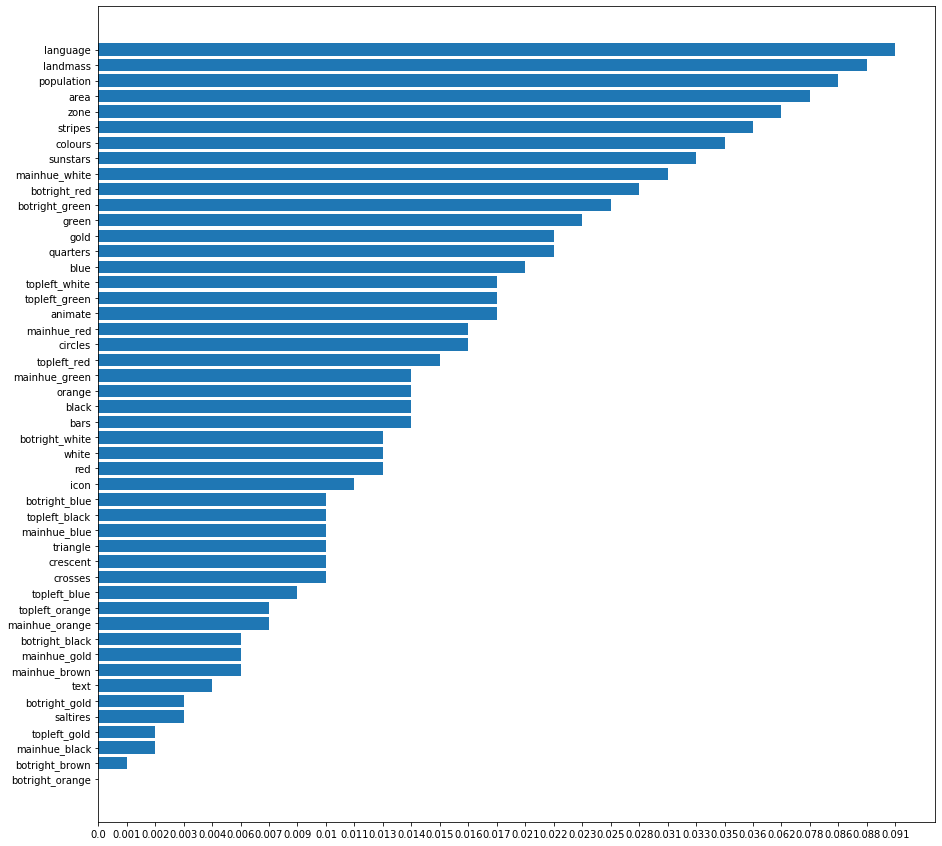

In [55]:
feat_imp_dict = {col:np.round(imp,3) for col,imp in zip(X_over.columns,rf_best.feature_importances_)}
feat_imp_dict = np.array(sorted(feat_imp_dict.items(),key=lambda x:x[1]))
labels = list(feat_imp_dict[:,0])
importances = list(feat_imp_dict[:,1])
y_pos = np.arange(len(labels))

plt.figure(figsize=(15,15))
plt.barh(y_pos,importances,align='center')
plt.yticks(y_pos, labels)
plt.show()